## Step 1 - Import Packages and Data

In [99]:
import random, os, sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import os 
import matplotlib.dates as mdates

#Data Processing
import numpy as np
import pandas as pd
from keras import backend as K
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle


#Model Development
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *

from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.metrics import *
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.python.keras.layers import Layer

In [2]:
#url = 'https://www.cryptodatadownload.com/cdd/Gemini_BTCUSD_d.csv'
url = 'https://www.cryptodatadownload.com/cdd/Gemini_BTCUSD_1hr.csv'

data = pd.read_csv(url, skiprows=1)

In [3]:
# Import the data from the url
df = pd.read_csv(url,skiprows=1,delimiter=',',usecols=['Date','Open','High','Low','Close', 'Volume'])
df.head()

,Date,Open,High,Low,Close,Volume
0,2022-05-16 08:00:00,29561.12,29734.01,29561.12,29734.01,10.182240
1,2022-05-16 07:00:00,29543.08,29705.39,29286.14,29561.12,22.222511
2,2022-05-16 06:00:00,30255.19,30255.19,29352.73,29543.08,106.232346
3,2022-05-16 05:00:00,30300.00,30429.09,30222.11,30255.19,9.238477
4,2022-05-16 04:00:00,30283.70,30396.76,30113.95,30300.00,16.313775


In [4]:
df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']].copy()
df = df.sort_values('Date')
df = df.set_index('Date')
df.head()


,Open,High,Low,Close,Volume
Date,,,,,
2015-10-08 13:00:00,0.00,245.00,0.00,245.00,0.606654
2015-10-08 14:00:00,245.00,245.00,244.50,245.00,4.453649
2015-10-08 15:00:00,245.00,245.00,244.92,244.92,3.016926
2015-10-08 16:00:00,244.92,244.92,244.25,244.25,3.895252
2015-10-08 17:00:00,244.25,244.99,244.02,244.99,3.920632


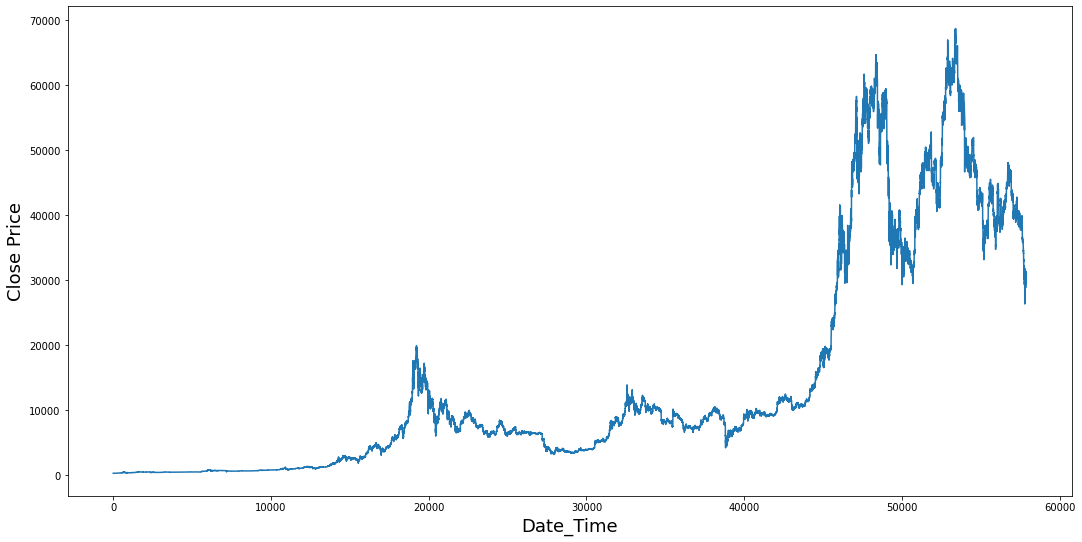

In [5]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Close']))
#plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date_Time',fontsize=18)
plt.ylabel('Close Price',fontsize=18)
plt.show()

## Step 2 - Data preprocessing 

In [6]:
SEQ_LEN = 72  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD = 12  # how far into the future are we trying to predict?
RATIO_TO_PREDICT = "Close"

In [7]:
times = sorted(df.index.values)  # get the times
last_10pct = sorted(df.index.values)[-int(0.1*len(times))]  # get the last 10% of the times
last_20pct = sorted(df.index.values)[-int(0.2*len(times))]  # get the last 20% of the times

test_df = df[(df.index >= last_10pct)]
validation_df = df[(df.index >= last_20pct) & (df.index < last_10pct)]  
train_df = df[(df.index < last_20pct)]  # now the train_df is all the data up to the last 20%

In [8]:
def add_gaussian_noise(signal):
    noise=np.random.normal(0,0.05,SEQ_LEN)
    return (signal+noise)


In [9]:
train_df.shape

(46305, 5)

In [10]:
train_df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2015-10-08 13:00:00,0.00,245.00,0.00,245.00,0.606654
2015-10-08 14:00:00,245.00,245.00,244.50,245.00,4.453649
2015-10-08 15:00:00,245.00,245.00,244.92,244.92,3.016926
2015-10-08 16:00:00,244.92,244.92,244.25,244.25,3.895252
2015-10-08 17:00:00,244.25,244.99,244.02,244.99,3.920632


In [11]:
train_ = train_df.values
valid_ = validation_df.values
test_ = test_df.values

In [12]:
print("train shape {0}".format(train_.shape))
print("valid shape {0}".format(valid_.shape))
print("test shape {0}".format(test_.shape))

train shape (46305, 5)
valid shape (5788, 5)
test shape (5788, 5)


In [13]:
scaler = MinMaxScaler()
scale_close = MinMaxScaler()

In [14]:
def myMinMax(X) :
  X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
  X_scaled = X_std * (max - min) + min
  return X_scaled

In [82]:
train_df_close = train_df['Close']
train_df_close.head()
train_df_close = train_df
close_ = train_df_close.values
close_ = close_.reshape(-1, 1)
scale_close.fit(close_)

MinMaxScaler()

In [15]:
scaler.fit(train_)

train_ = scaler.transform(train_)

valid_ = scaler.transform(valid_)
test_ = scaler.transform(test_)

In [16]:
train_.shape
print(len(train_))

46305


In [17]:
length = len(train_)
  
# Now perform exponential moving average smoothing for smooth curve of data
EMA = 0.0
gamma = 0.1
for ti in range(length):
    EMA = gamma*train_[ti] + (1-gamma)*EMA
    train_[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_,valid_, test_],axis=0)

In [18]:
def split_data(data):
    X = []
    Y = []
    for i in range(SEQ_LEN, len(data)-FUTURE_PERIOD+1):
        X.append(data[i-SEQ_LEN:i])
        Y.append(data[i+(FUTURE_PERIOD-1), 3])
    return np.array(X), np.array(Y)

In [19]:
X_train, y_train = split_data(train_)
X_test, y_test = split_data(test_)
X_valid, y_valid = split_data(valid_)

In [20]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 5))
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 5))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 5))

In [86]:
reformated_test = y_test.reshape(-1, 1)
original_test = scale_close.inverse_transform(reformated_test)

In [21]:
y_train.shape

(46222,)

In [22]:
y_valid.shape

(5705,)

In [23]:
print("train shape {0}".format(X_train.shape))
print("valid shape {0}".format(X_valid.shape))
print("test shape {0}".format(X_test.shape))

train shape (46222, 72, 5)
valid shape (5705, 72, 5)
test shape (5705, 72, 5)


In [24]:
X_train_2, y_train_2 = split_data(train_)
X_train_2 = np.reshape(X_train_2, (X_train_2.shape[0], X_train_2.shape[1], 5))

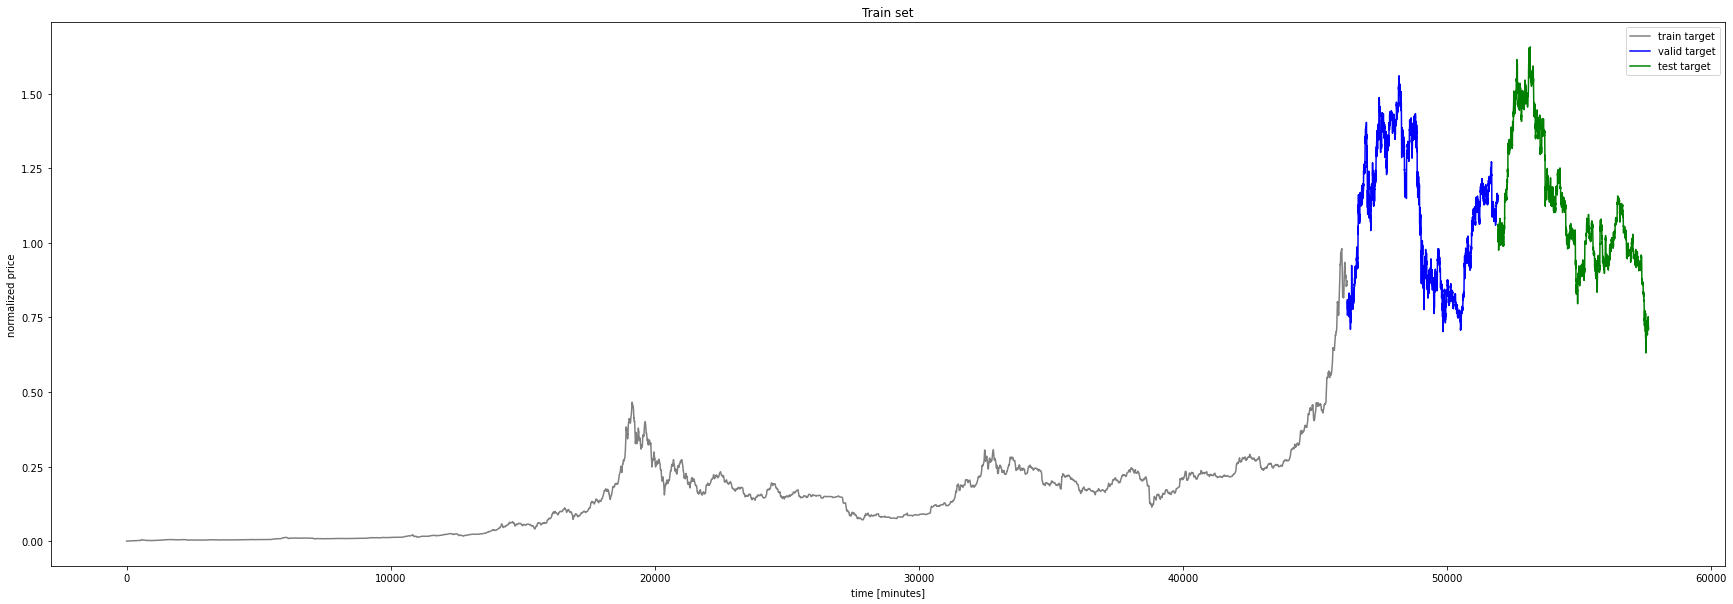

In [25]:
## show predictions
plt.figure(figsize=(30, 10))

plt.plot(np.arange(y_train_2.shape[0]), y_train_2, color='gray', label='train target')

plt.plot(np.arange(y_train_2.shape[0], y_train_2.shape[0]+y_valid.shape[0]), y_valid,
         color='blue', label='valid target')

plt.plot(np.arange(y_train_2.shape[0]+y_valid.shape[0],
                   y_train_2.shape[0]+y_valid.shape[0]+y_test.shape[0]),
         y_test, color='green', label='test target')


plt.title('Train set')
plt.xlabel('time [minutes]')
plt.ylabel('normalized price')
plt.legend(loc='best');

In [26]:
X_train, y_train = shuffle(X_train, y_train)

In [186]:
print("X valid shape {0}".format(X_test.shape))
print("y valid shape {0}".format(y_valid.shape))

X valid shape (5705, 72, 5)
y valid shape (5705,)


Model




# Developing The Model

In [27]:
EPOCHS = 60  # how many passes through our data
BATCH_SIZE = 256  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
import time

NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD}-PRED-{int(time.time())}"  # a unique name for the model

In [28]:
import random, os, sys
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.python.keras.layers import Layer

In [29]:
def build_lstm():
    model = Sequential() 
    #56 and 102
    model.add(LSTM(units = 56, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], 5)))
    model.add(Dropout(0.2)) 
    model.add(LSTM(units = 102, activation = 'relu', return_sequences = False))
    model.add(Dropout(0.3)) 
    model.add(Dense(units =1))
    

    start = time.time()


    opt = tf.keras.optimizers.Adam(learning_rate=0.0001, )

    model.compile(
        loss='mse',
        metrics=[
          #MeanSquaredError(),
          MeanAbsoluteError(),
          MeanAbsolutePercentageError(),
          #tf.keras.metrics.AUC(),
          RootMeanSquaredError(),
        ],
        optimizer=opt)

    print("> Compilation Time : ", time.time() - start)
    return model

def build_lstm():
    model = Sequential() 
    #56 and 102
    model.add(LSTM(units = 60, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], 5)))
    model.add(Dropout(0.2)) 
    model.add(LSTM(units = 120, activation = 'relu', return_sequences = False))
    model.add(Dropout(0.3)) 
    model.add(Dense(units =1))
    

    start = time.time()


    opt = tf.keras.optimizers.Adam(learning_rate=0.0001, )

    model.compile(
        loss='mse',
        metrics=[
          #MeanSquaredError(),
          MeanAbsoluteError(),
          MeanAbsolutePercentageError(),
          #tf.keras.metrics.AUC(),
          RootMeanSquaredError(),
        ],
        optimizer=opt)

    print("> Compilation Time : ", time.time() - start)
    return model

def build_gru():
    model = Sequential() 
    model.add(GRU(units = 60, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], 5)))
    model.add(Dropout(0.2)) 
    model.add(GRU(units = 120, activation = 'relu', return_sequences = False))
    model.add(Dropout(0.3)) 
    model.add(Dense(units =1))
    

    start = time.time()


    opt = tf.keras.optimizers.Adam(learning_rate=0.0005, )

    model.compile(
        loss='mse',
        metrics=[
          #MeanSquaredError(),
          MeanAbsoluteError(),
          MeanAbsolutePercentageError(),
          #tf.keras.metrics.AUC(),
          RootMeanSquaredError(),
        ],
        optimizer=opt)

    print("> Compilation Time : ", time.time() - start)
    return model

def build_bilstm():
    model = Sequential() 
    model.add(Bidirectional(LSTM(units = 60, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], 5))))
    model.add(Dropout(0.2)) 
    model.add(Bidirectional(LSTM(units = 120, activation = 'relu', return_sequences = False)))
    model.add(Dropout(0.3)) 
    model.add(Dense(units =1))
    

    start = time.time()


    opt = tf.keras.optimizers.Adam(learning_rate=0.0005, )

    model.compile(
        loss='mse',
        metrics=[
          #MeanSquaredError(),
          MeanAbsoluteError(),
          MeanAbsolutePercentageError(),
          #tf.keras.metrics.AUC(),
          RootMeanSquaredError(),
        ],
        optimizer=opt)

    print("> Compilation Time : ", time.time() - start)
    return model


def build_bilstm():
    model = Sequential() 
    model.add(Bidirectional(LSTM(units = 60, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], 5))))
    model.add(Dropout(0.2)) 
    model.add(Bidirectional(LSTM(units = 120, activation = 'relu', return_sequences = False)))
    model.add(Dropout(0.3)) 
    model.add(Dense(units =1))
    

    start = time.time()


    opt = tf.keras.optimizers.Adam(learning_rate=0.0005, )

    model.compile(
        loss='mse',
        metrics=[
          #MeanSquaredError(),
          MeanAbsoluteError(),
          MeanAbsolutePercentageError(),
          #tf.keras.metrics.AUC(),
          RootMeanSquaredError(),
        ],
        optimizer=opt)

    print("> Compilation Time : ", time.time() - start)
    return model


In [30]:
callback = EarlyStopping(monitor='val_loss',
                         patience=12,
                         restore_best_weights=True)

## LSTM Model

In [31]:
#lstm_model = build_model()
lstm_model = build_lstm()
#lstm_model = build_network2()

> Compilation Time :  0.017586469650268555


In [32]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 72, 60)            15840     
                                                                 
 dropout (Dropout)           (None, 72, 60)            0         
                                                                 
 lstm_1 (LSTM)               (None, 120)               86880     
                                                                 
 dropout_1 (Dropout)         (None, 120)               0         
                                                                 
 dense (Dense)               (None, 1)                 121       
                                                                 
Total params: 102,841
Trainable params: 102,841
Non-trainable params: 0
_________________________________________________________________


Training

In [ ]:
lstm_history = lstm_model.fit(x=X_train, 
                         y=y_train,
                         batch_size=BATCH_SIZE,
                         epochs=EPOCHS,
                         validation_data=(X_valid, y_valid), 
                         callbacks=[callback])

Epoch 1/60
181/181 [==============================] - 70s 341ms/step - loss: 0.0053 - mean_absolute_error: 0.0426 - mean_absolute_percentage_error: 217.2554 - root_mean_squared_error: 0.0726 - val_loss: 0.0847 - val_mean_absolute_error: 0.2177 - val_mean_absolute_percentage_error: 17.5576 - val_root_mean_squared_error: 0.2911
Epoch 2/60
181/181 [==============================] - 43s 237ms/step - loss: 5.1113e-04 - mean_absolute_error: 0.0135 - mean_absolute_percentage_error: 33.7686 - root_mean_squared_error: 0.0226 - val_loss: 0.0121 - val_mean_absolute_error: 0.0823 - val_mean_absolute_percentage_error: 6.8683 - val_root_mean_squared_error: 0.1099
Epoch 3/60
181/181 [==============================] - 43s 237ms/step - loss: 4.2495e-04 - mean_absolute_error: 0.0124 - mean_absolute_percentage_error: 30.6586 - root_mean_squared_error: 0.0206 - val_loss: 0.0072 - val_mean_absolute_error: 0.0650 - val_mean_absolute_percentage_error: 5.5907 - val_root_mean_squared_error: 0.0847
Epoch 4/60
1

In [ ]:

loss = lstm_history.history['loss']
val_loss = lstm_history.history['val_loss']
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [35]:
print(X_test[0][0])

[1.1585161  1.1476653  1.17012291 1.15816158 0.00141921]


In [36]:
print(X_test.shape)

(5705, 72, 5)


In [ ]:
pred_lstm = lstm_model.predict(X_test)
#predicted_stock_price_multi_head = scaler.inverse_transform(predicted_stock_price_multi_head)


pred_lstm.shape

In [ ]:
pred_lstm = np.vstack((np.full((120,1), np.nan), pred_lstm))

###Analaysing Results

In [ ]:
#removing first 120 results as that is the window of gap
rem_pred_lstm = pred_lstm[120:]
print(rem_pred_lstm.shape)

In [83]:
convert_lstm = scale_close.inverse_transform(rem_pred_lstm)

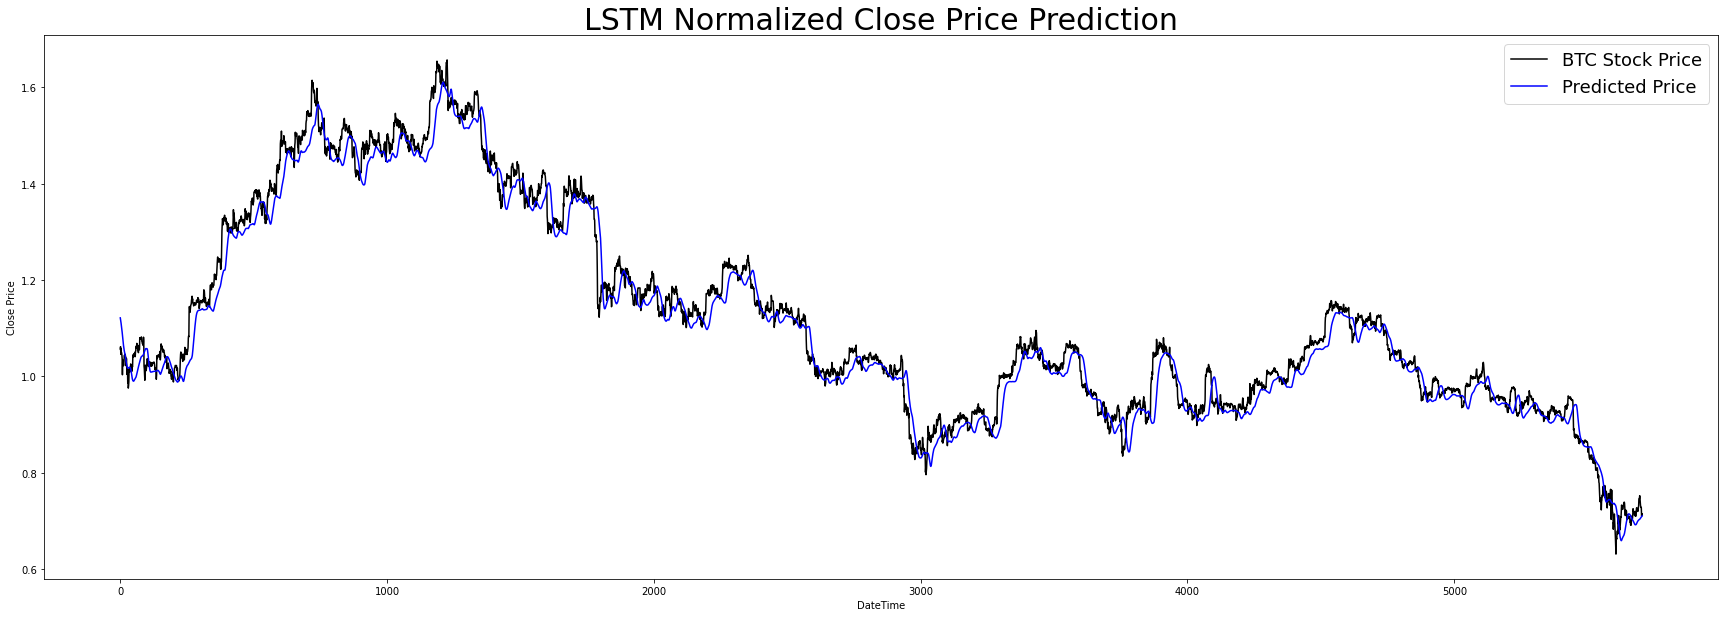

In [181]:
plt.figure(figsize=(30, 10))
plt.plot(y_test, color = 'black', label = 'BTC Stock Price')
plt.plot(rem_pred_lstm, color = 'blue', label = 'Predicted Price')
plt.title('LSTM Normalized Close Price Prediction', fontsize=30)
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('DateTime')
plt.ylabel('Close Price')
plt.legend(fontsize=18)
plt.show()

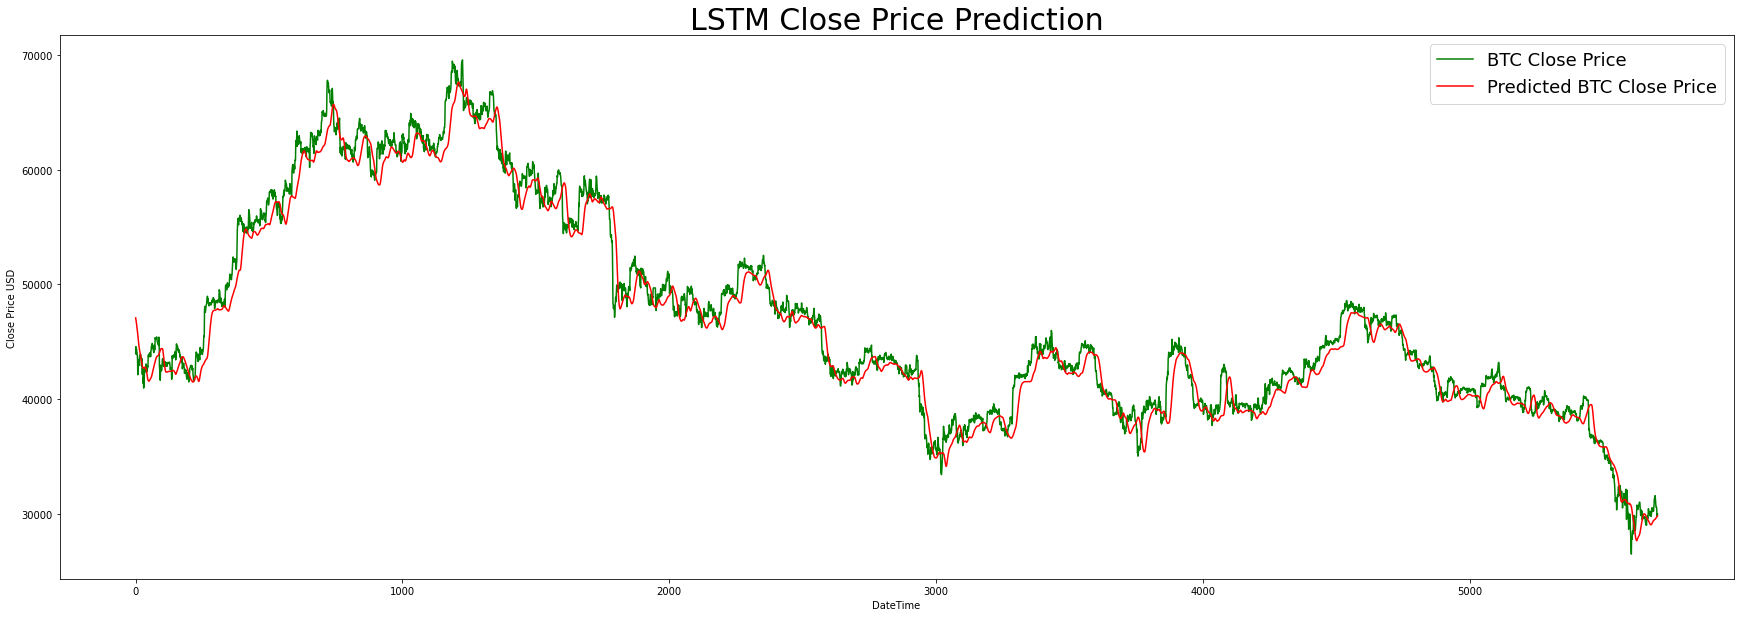

In [182]:
plt.figure(figsize=(30, 10))
plt.plot(original_test, color = 'green', label = 'BTC Close Price')
plt.plot(convert_lstm, color = 'red', label = 'Predicted BTC Close Price')
plt.title('LSTM Close Price Prediction', fontsize=30)
plt.xlabel('DateTime')
plt.ylabel('Close Price USD')
plt.legend(fontsize=18)
plt.show()
plt.close()

In [158]:
from sklearn.metrics import *

expy = explained_variance_score(y_test, rem_pred_lstm)
expy_string = 'Explained Variance Score : {}'.format(expy)
print(expy_string)
max_error(y_test, rem_pred_lstm)
mean_absolute_error(y_test, rem_pred_lstm)
mean_squared_error(y_test, rem_pred_lstm)
mean_squared_log_error(y_test, rem_pred_lstm)
median_absolute_error(y_test, rem_pred_lstm)
mape = mean_absolute_percentage_error(y_test, rem_pred_lstm)
mape_string = 'Mean Absolute Percentage Error : {}'.format(mape)
print(mape_string)
r2_score(y_test, rem_pred_lstm)
mpd = mean_poisson_deviance(y_test, rem_pred_lstm)
mean_gamma_deviance(y_test, rem_pred_lstm)
mean_tweedie_deviance(y_test, rem_pred_lstm)
d2_tweedie_score(y_test, rem_pred_lstm)
mean_pinball_loss(y_test, rem_pred_lstm)


r2 =r2_score(y_test, rem_pred_lstm)
r2_string = 'R2 Score : {}'.format(r2)
print(r2_string)

Explained Variance Score : 0.9764412386431712
Mean Absolute Percentage Error : 0.024583315162298402
R2 Score : 0.971785004401008


## GRU Model


In [ ]:
gru_model = build_gru()

In [ ]:
gru_model.summary()

In [ ]:
gru_history = gru_model.fit(x=X_train, 
                         y=y_train,
                         batch_size=128,
                         epochs=EPOCHS,
                         validation_data=(X_valid, y_valid), 
                         callbacks=[callback])

Epoch 1/60
362/362 [==============================] - 101s 273ms/step - loss: 0.0013 - mean_absolute_error: 0.0186 - mean_absolute_percentage_error: 73.8097 - root_mean_squared_error: 0.0354 - val_loss: 0.0022 - val_mean_absolute_error: 0.0356 - val_mean_absolute_percentage_error: 3.2537 - val_root_mean_squared_error: 0.0469
Epoch 2/60
362/362 [==============================] - 98s 271ms/step - loss: 3.8238e-04 - mean_absolute_error: 0.0121 - mean_absolute_percentage_error: 42.1005 - root_mean_squared_error: 0.0196 - val_loss: 0.0017 - val_mean_absolute_error: 0.0316 - val_mean_absolute_percentage_error: 2.9529 - val_root_mean_squared_error: 0.0411
Epoch 3/60
362/362 [==============================] - 98s 272ms/step - loss: 3.2467e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 41.8740 - root_mean_squared_error: 0.0180 - val_loss: 0.0016 - val_mean_absolute_error: 0.0306 - val_mean_absolute_percentage_error: 2.8368 - val_root_mean_squared_error: 0.0402
Epoch 4/60
36

In [ ]:

loss = gru_history.history['loss']
val_loss = gru_history.history['val_loss']
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

###Analysing Results

In [ ]:
pred_gru = gru_model.predict(X_test)
#predicted_stock_price_multi_head = scaler.inverse_transform(predicted_stock_price_multi_head)


pred_gru.shape

pred_gru = np.vstack((np.full((120,1), np.nan), pred_gru))

In [117]:
#removing first 120 results as that is the window of gap
rem_pred_gru = pred_gru[120:]

In [118]:
convert_gru = scale_close.inverse_transform(rem_pred_gru)

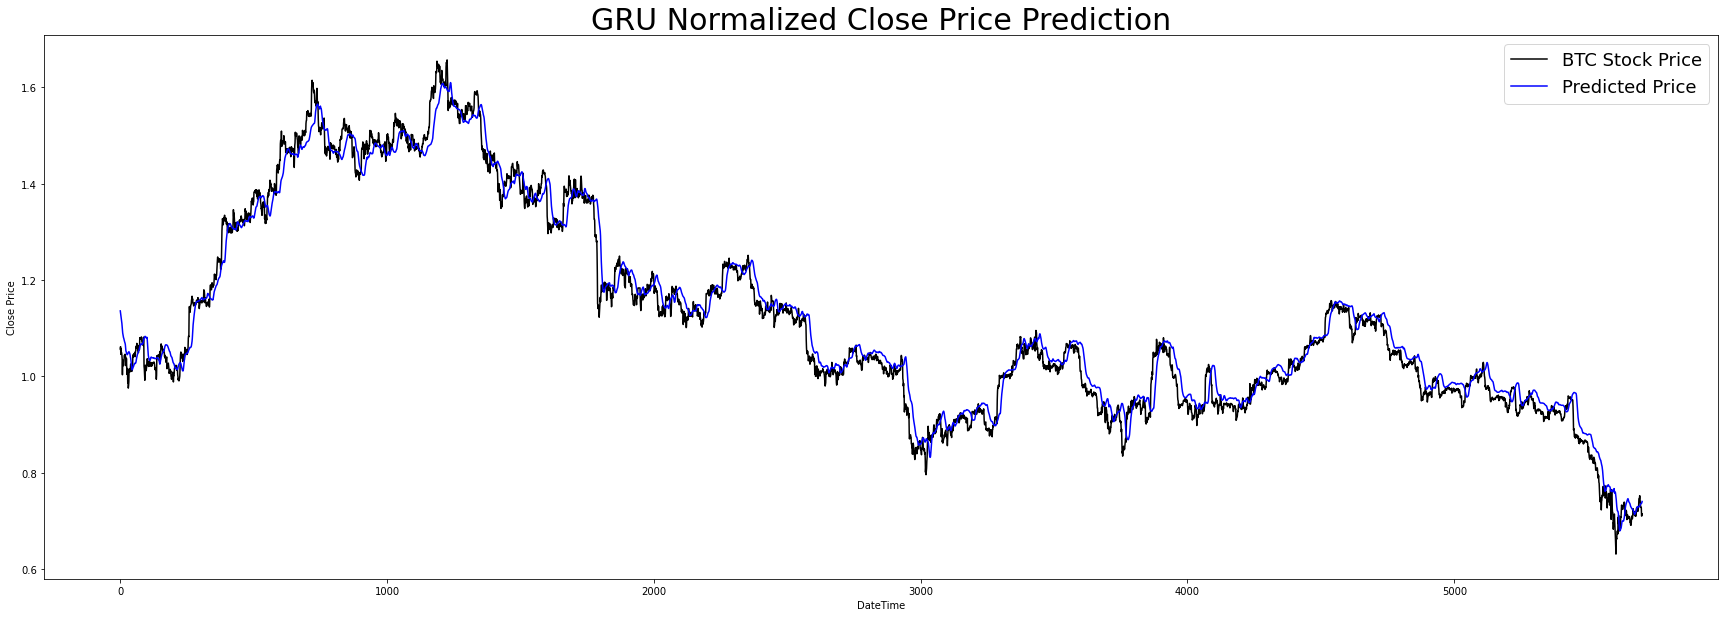

In [178]:
plt.figure(figsize=(30, 10))
plt.plot(y_test, color = 'black', label = 'BTC Stock Price')
plt.plot(rem_pred_gru, color = 'blue', label = 'Predicted Price')
plt.title('GRU Normalized Close Price Prediction', fontsize=30)
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('DateTime')
plt.ylabel('Close Price')
plt.legend(fontsize=18)
plt.show()

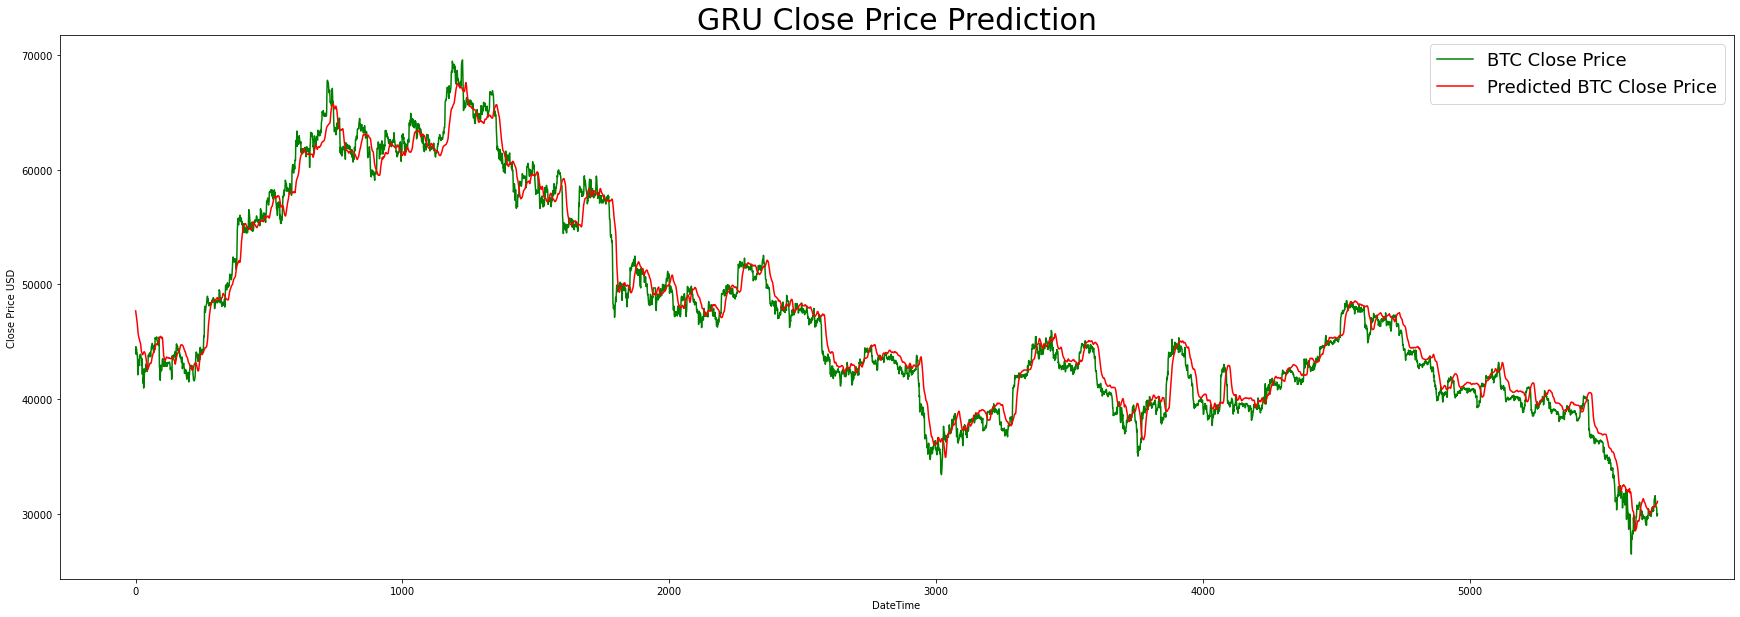

In [177]:
plt.figure(figsize=(30, 10))
plt.plot(original_test, color = 'green', label = 'BTC Close Price')
plt.plot(convert_gru, color = 'red', label = 'Predicted BTC Close Price')
plt.title('GRU Close Price Prediction', fontsize=30)
plt.xlabel('DateTime')
plt.ylabel('Close Price USD')
plt.legend(fontsize=18)
plt.show()
plt.close()

In [159]:
from sklearn.metrics import *

expy = explained_variance_score(y_test, rem_pred_gru)
expy_string = 'Explained Variance Score : {}'.format(expy)
print(expy_string)
max_error(y_test, rem_pred_gru)
mean_absolute_error(y_test, rem_pred_gru)
mean_squared_error(y_test, rem_pred_gru)
mean_squared_log_error(y_test, rem_pred_gru)
median_absolute_error(y_test, rem_pred_gru)
mape = mean_absolute_percentage_error(y_test, rem_pred_gru)
mape_string = 'Mean Absolute Percentage Error : {}'.format(mape)
print(mape_string)
r2_score(y_test, rem_pred_gru)
mpd = mean_poisson_deviance(y_test, rem_pred_gru)
mean_gamma_deviance(y_test, rem_pred_gru)
mean_tweedie_deviance(y_test, rem_pred_gru)
d2_tweedie_score(y_test, rem_pred_gru)
mean_pinball_loss(y_test, rem_pred_gru)


r2 =r2_score(y_test, rem_pred_gru)
r2_string = 'R2 Score : {}'.format(r2)
print(r2_string)

Explained Variance Score : 0.9783305226606047
Mean Absolute Percentage Error : 0.0220535538576336
R2 Score : 0.9771994979226912


## Bi-LSTM Model


In [52]:
bi_model = build_bilstm()

> Compilation Time :  0.014890670776367188


In [53]:
bi_history = bi_model.fit(x=X_train, 
                         y=y_train,
                         batch_size=256,
                         epochs=EPOCHS,
                         validation_data=(X_valid, y_valid), 
                         callbacks=[callback])



Epoch 1/60
181/181 [==============================] - 85s 450ms/step - loss: 0.0013 - mean_absolute_error: 0.0184 - mean_absolute_percentage_error: 64.5255 - root_mean_squared_error: 0.0358 - val_loss: 0.0049 - val_mean_absolute_error: 0.0529 - val_mean_absolute_percentage_error: 4.7739 - val_root_mean_squared_error: 0.0702
Epoch 2/60
181/181 [==============================] - 83s 456ms/step - loss: 3.2856e-04 - mean_absolute_error: 0.0107 - mean_absolute_percentage_error: 24.8381 - root_mean_squared_error: 0.0181 - val_loss: 0.0098 - val_mean_absolute_error: 0.0812 - val_mean_absolute_percentage_error: 7.2006 - val_root_mean_squared_error: 0.0991
Epoch 3/60
181/181 [==============================] - 105s 579ms/step - loss: 2.8410e-04 - mean_absolute_error: 0.0098 - mean_absolute_percentage_error: 22.8989 - root_mean_squared_error: 0.0169 - val_loss: 0.0026 - val_mean_absolute_error: 0.0405 - val_mean_absolute_percentage_error: 3.6772 - val_root_mean_squared_error: 0.0509
Epoch 4/60
18

In [54]:
bi_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 72, 120)          31680     
 l)                                                              
                                                                 
 dropout_4 (Dropout)         (None, 72, 120)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 240)              231360    
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 240)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 241       
                                                                 
Total params: 263,281
Trainable params: 263,281
Non-tr

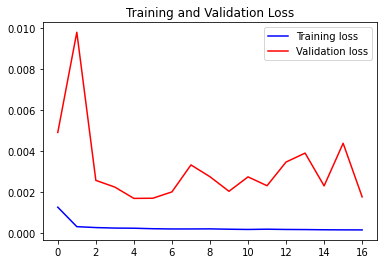

In [55]:

loss = bi_history.history['loss']
val_loss = bi_history.history['val_loss']
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

###Analysing Results

In [56]:
pred_bi = bi_model.predict(X_test)
#predicted_stock_price_multi_head = scaler.inverse_transform(predicted_stock_price_multi_head)


pred_bi.shape

pred_bi = np.vstack((np.full((120,1), np.nan), pred_bi))

In [57]:
rem_pred_bi = pred_bi[120:]
rem_pred_bi.shape

(5705, 1)

In [120]:
convert_bi = scale_close.inverse_transform(rem_pred_bi)

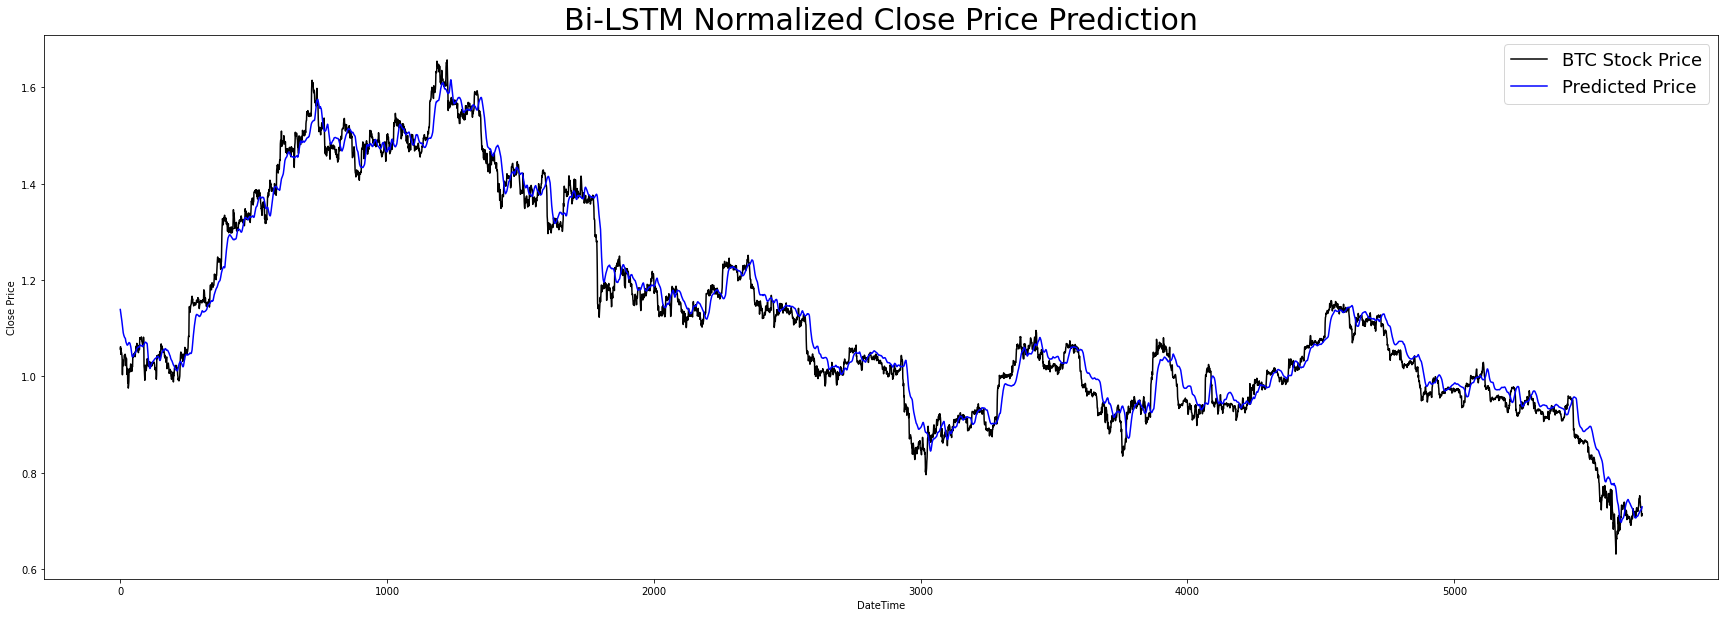

In [179]:
plt.figure(figsize=(30, 10))
plt.plot(y_test, color = 'black', label = 'BTC Stock Price')
plt.plot(rem_pred_bi, color = 'blue', label = 'Predicted Price')
plt.title('Bi-LSTM Normalized Close Price Prediction', fontsize=30)
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('DateTime')
plt.ylabel('Close Price')
plt.legend(fontsize=18)
plt.show()

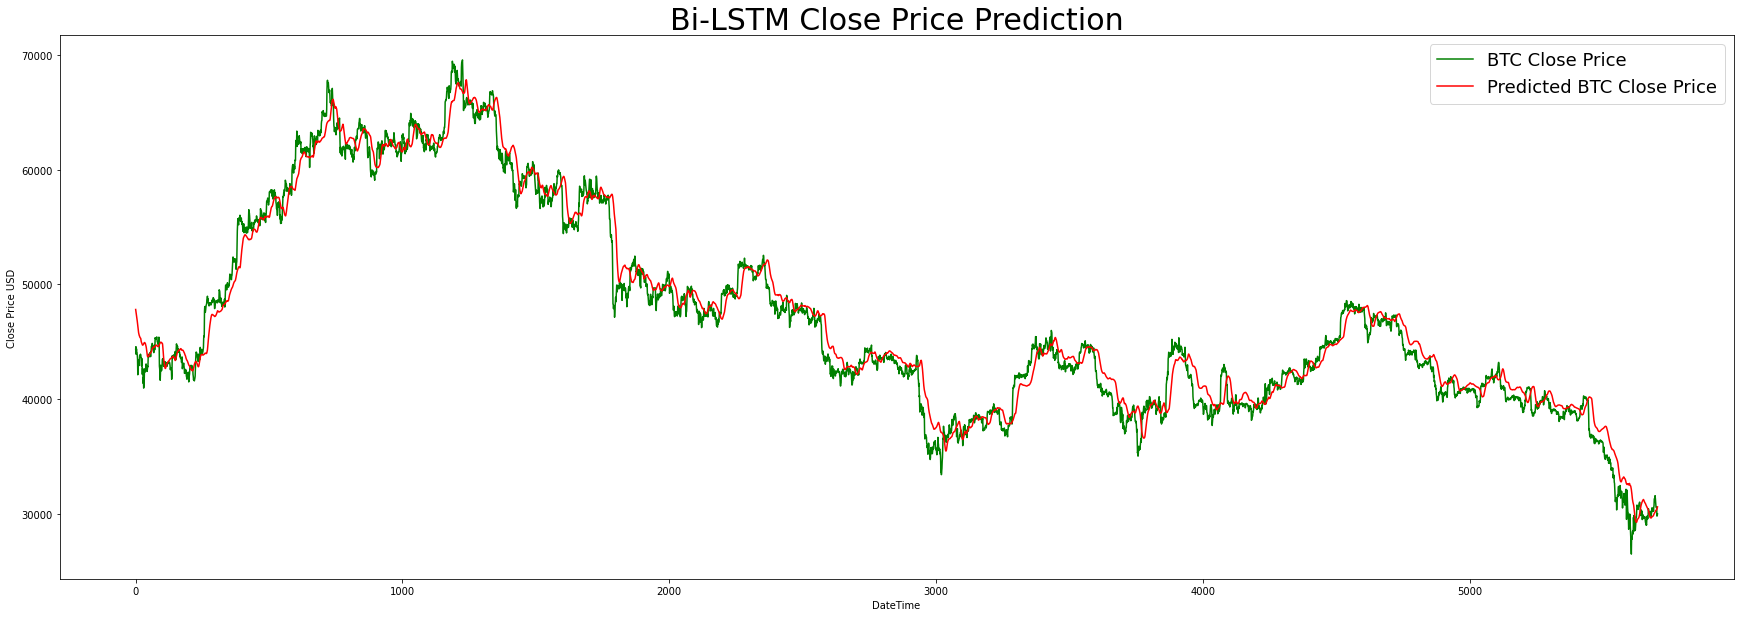

In [180]:
plt.figure(figsize=(30, 10))
plt.plot(original_test, color = 'green', label = 'BTC Close Price')
plt.plot(convert_bi, color = 'red', label = 'Predicted BTC Close Price')
plt.title('Bi-LSTM Close Price Prediction', fontsize=30)
plt.xlabel('DateTime')
plt.ylabel('Close Price USD')
plt.legend(fontsize=18)
plt.show()
plt.close()

In [160]:
from sklearn.metrics import *

expy = explained_variance_score(y_test, rem_pred_bi)
expy_string = 'Explained Variance Score : {}'.format(expy)
print(expy_string)
max_error(y_test, rem_pred_bi)
mean_absolute_error(y_test, rem_pred_bi)
mean_squared_error(y_test, rem_pred_bi)
mean_squared_log_error(y_test, rem_pred_bi)
median_absolute_error(y_test, rem_pred_bi)
mape = mean_absolute_percentage_error(y_test, rem_pred_bi)
mape_string = 'Mean Absolute Percentage Error : {}'.format(mape)
print(mape_string)
r2_score(y_test, rem_pred_bi)
mpd = mean_poisson_deviance(y_test, rem_pred_bi)
mean_gamma_deviance(y_test, rem_pred_bi)
mean_tweedie_deviance(y_test, rem_pred_bi)
d2_tweedie_score(y_test, rem_pred_bi)
mean_pinball_loss(y_test, rem_pred_bi)


r2 =r2_score(y_test, rem_pred_bi)
r2_string = 'R2 Score : {}'.format(r2)
print(r2_string)

Explained Variance Score : 0.9756784974506815
Mean Absolute Percentage Error : 0.02366633701625547
R2 Score : 0.9745046810905619


## Transformer Model

In [133]:
import random, os, sys
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
import tensorflow as tf
from tensorflow.python.keras.layers import Layer

try:
    from dataloader import TokenList, pad_to_longest
    # for transformer
except: pass



embed_size = 60

class LayerNormalization(Layer):
    def __init__(self, eps=1e-6, **kwargs):
        self.eps = eps
        super(LayerNormalization, self).__init__(**kwargs)
    def build(self, input_shape):
        self.gamma = self.add_weight(name='gamma', shape=input_shape[-1:],
                                     initializer=Ones(), trainable=True)
        self.beta = self.add_weight(name='beta', shape=input_shape[-1:],
                                    initializer=Zeros(), trainable=True)
        super(LayerNormalization, self).build(input_shape)
    def call(self, x):
        mean = K.mean(x, axis=-1, keepdims=True)
        std = K.std(x, axis=-1, keepdims=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta
    def compute_output_shape(self, input_shape):
        return input_shape

class ScaledDotProductAttention():
    def __init__(self, d_model, attn_dropout=0.1):
        self.temper = np.sqrt(d_model)
        self.dropout = Dropout(attn_dropout)
    def __call__(self, q, k, v, mask):
        attn = Lambda(lambda x:K.batch_dot(x[0],x[1],axes=[2,2])/self.temper)([q, k])
        if mask is not None:
            mmask = Lambda(lambda x:(-1e+10)*(1-x))(mask)
            attn = Add()([attn, mmask])
        attn = Activation('softmax')(attn)
        attn = self.dropout(attn)
        output = Lambda(lambda x:K.batch_dot(x[0], x[1]))([attn, v])
        return output, attn

class MultiHeadAttention():
    # mode 0 - big martixes, faster; mode 1 - more clear implementation
    def __init__(self, n_head, d_model, d_k, d_v, dropout, mode=0, use_norm=True):
        self.mode = mode
        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v
        self.dropout = dropout
        if mode == 0:
            self.qs_layer = Dense(n_head*d_k, use_bias=False)
            self.ks_layer = Dense(n_head*d_k, use_bias=False)
            self.vs_layer = Dense(n_head*d_v, use_bias=False)
        elif mode == 1:
            self.qs_layers = []
            self.ks_layers = []
            self.vs_layers = []
            for _ in range(n_head):
                self.qs_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.ks_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.vs_layers.append(TimeDistributed(Dense(d_v, use_bias=False)))
        self.attention = ScaledDotProductAttention(d_model)
        self.layer_norm = LayerNormalization() if use_norm else None
        self.w_o = TimeDistributed(Dense(d_model))

    def __call__(self, q, k, v, mask=None):
        d_k, d_v = self.d_k, self.d_v
        n_head = self.n_head

        if self.mode == 0:
            qs = self.qs_layer(q)  # [batch_size, len_q, n_head*d_k]
            ks = self.ks_layer(k)
            vs = self.vs_layer(v)

            def reshape1(x):
                s = tf.shape(x)   # [batch_size, len_q, n_head * d_k]
                x = tf.reshape(x, [s[0], s[1], n_head, d_k])
                x = tf.transpose(x, [2, 0, 1, 3])  
                x = tf.reshape(x, [-1, s[1], d_k])  # [n_head * batch_size, len_q, d_k]
                return x
            qs = Lambda(reshape1)(qs)
            ks = Lambda(reshape1)(ks)
            vs = Lambda(reshape1)(vs)

            if mask is not None:
                mask = Lambda(lambda x:K.repeat_elements(x, n_head, 0))(mask)
            head, attn = self.attention(qs, ks, vs, mask=mask)  
                
            def reshape2(x):
                s = tf.shape(x)   # [n_head * batch_size, len_v, d_v]
                x = tf.reshape(x, [n_head, -1, s[1], s[2]]) 
                x = tf.transpose(x, [1, 2, 0, 3])
                x = tf.reshape(x, [-1, s[1], n_head*d_v])  # [batch_size, len_v, n_head * d_v]
                return x
            head = Lambda(reshape2)(head)
        elif self.mode == 1:
            heads = []; attns = []
            for i in range(n_head):
                qs = self.qs_layers[i](q)   
                ks = self.ks_layers[i](k) 
                vs = self.vs_layers[i](v) 
                head, attn = self.attention(qs, ks, vs, mask)
                heads.append(head); attns.append(attn)
            head = Concatenate()(heads) if n_head > 1 else heads[0]
            attn = Concatenate()(attns) if n_head > 1 else attns[0]

        outputs = self.w_o(head)
        outputs = Dropout(self.dropout)(outputs)
        if not self.layer_norm: return outputs, attn
        # outputs = Add()([outputs, q]) # sl: fix
        return self.layer_norm(outputs), attn

class PositionwiseFeedForward():
    def __init__(self, d_hid, d_inner_hid, dropout=0.1):
        self.w_1 = Conv1D(d_inner_hid, 1, activation='relu')
        self.w_2 = Conv1D(d_hid, 1)
        self.layer_norm = LayerNormalization()
        self.dropout = Dropout(dropout)
    def __call__(self, x):
        output = self.w_1(x) 
        output = self.w_2(output)
        output = self.dropout(output)
        output = Add()([output, x])
        return self.layer_norm(output)

class EncoderLayer():
    def __init__(self, d_model, d_inner_hid, n_head, d_k, d_v, dropout=0.1):
        self.self_att_layer = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn_layer  = PositionwiseFeedForward(d_model, d_inner_hid, dropout=dropout)
    def __call__(self, enc_input, mask=None):
        output, slf_attn = self.self_att_layer(enc_input, enc_input, enc_input, mask=mask)
        output = self.pos_ffn_layer(output)
        return output, slf_attn


def GetPosEncodingMatrix(max_len, d_emb):
    pos_enc = np.array([
        [pos / np.power(10000, 2 * (j // 2) / d_emb) for j in range(d_emb)] 
        if pos != 0 else np.zeros(d_emb) 
            for pos in range(max_len)
            ])
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2]) # dim 2i
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2]) # dim 2i+1
    return pos_enc

def GetPadMask(q, k):
    ones = K.expand_dims(K.ones_like(q, 'float32'), -1)
    mask = K.cast(K.expand_dims(K.not_equal(k, 0), 1), 'float32')
    mask = K.batch_dot(ones, mask, axes=[2,1])
    return mask

def GetSubMask(s):
    len_s = tf.shape(s)[1]
    bs = tf.shape(s)[:1]
    mask = K.cumsum(tf.eye(len_s, batch_shape=bs), 1)
    return mask

class Transformer():
    def __init__(self, len_limit, embedding_matrix, d_model=embed_size, \
              d_inner_hid=512, n_head=10, d_k=64, d_v=64, layers=2, dropout=0.1, \
              share_word_emb=False, **kwargs):
        self.name = 'Transformer'
        self.len_limit = len_limit
        self.src_loc_info = False # True # sl: fix later
        self.d_model = d_model
        self.decode_model = None
        d_emb = d_model

        pos_emb = Embedding(len_limit, d_emb, trainable=False, \
                            weights=[GetPosEncodingMatrix(len_limit, d_emb)])

        i_word_emb = Embedding(max_features, d_emb, weights=[embedding_matrix]) # Add Kaggle provided embedding here

        self.encoder = Encoder(d_model, d_inner_hid, n_head, d_k, d_v, layers, dropout, \
                               word_emb=i_word_emb, pos_emb=pos_emb)

        
    def get_pos_seq(self, x):
        mask = K.cast(K.not_equal(x, 0), 'int32')
        pos = K.cumsum(K.ones_like(x, 'int32'), 1)
        return pos * mask

    def compile(self, active_layers=999):
        src_seq_input = Input(shape=(None, ))
        x = Embedding(max_features, embed_size, weights=[embedding_matrix])(src_seq_input)
        
        # LSTM before attention layers
        x = Bidirectional(LSTM(128, return_sequences=True))(x)
        x = Bidirectional(LSTM(64, return_sequences=True))(x) 
        
        x, slf_attn = MultiHeadAttention(n_head=3, d_model=300, d_k=64, d_v=64, dropout=0.1)(x, x, x)
        
        avg_pool = GlobalAveragePooling1D()(x)
        max_pool = GlobalMaxPooling1D()(x)
        conc = concatenate([avg_pool, max_pool])
        conc = Dense(64, activation="relu")(conc)
        x = Dense(1, activation="sigmoid")(conc)   
        
        
        self.model = Model(inputs=src_seq_input, outputs=x)
        self.model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['accuracy'])

In [162]:
def build_model():
    inp = Input(shape = (SEQ_LEN, 5))
    
    # LSTM before attention layers
    x = Bidirectional(LSTM(60, return_sequences=True, activation = 'relu'))(inp)
    x = Bidirectional(LSTM(120, activation = 'relu',return_sequences=True))(x) 
        
    x, slf_attn = MultiHeadAttention(n_head=3, d_model=150, d_k=32, d_v=32, dropout=0.1)(x, x, x)
        
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool])
    conc = Dense(32, activation="relu")(conc)

    x = Dense(1, activation="sigmoid")(conc)      

    model = Model(inputs = inp, outputs = x)

    opt = tf.keras.optimizers.Adam(learning_rate=0.0001, )

    model.compile(
        loss = "mean_squared_error", 
        metrics=[
          #MeanSquaredError(),
          MeanAbsoluteError(),
          MeanAbsolutePercentageError(),
          #tf.keras.metrics.AUC(),
          RootMeanSquaredError(),
        ],
        #optimizer = Adam(lr = config["lr"], decay = config["lr_d"]), 
        optimizer = opt)
    
    # Save entire model to a HDF5 file
    #model.save('my_model.h5')
    
    return model

In [163]:
trans_model = build_model()

In [164]:
trans_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 72, 5)]      0           []                               
                                                                                                  
 bidirectional_12 (Bidirectiona  (None, 72, 120)     31680       ['input_6[0][0]']                
 l)                                                                                               
                                                                                                  
 bidirectional_13 (Bidirectiona  (None, 72, 240)     231360      ['bidirectional_12[0][0]']       
 l)                                                                                               
                                                                                            

In [166]:
trans_history = trans_model.fit(x=X_train, 
                         y=y_train,
                         batch_size=1028,
                         epochs=EPOCHS,
                         validation_data=(X_valid, y_valid), 
                         callbacks=[callback])

Epoch 1/60
45/45 [==============================] - 28s 524ms/step - loss: 0.0094 - mean_absolute_error: 0.0515 - mean_absolute_percentage_error: 118.5801 - root_mean_squared_error: 0.0971 - val_loss: 0.3137 - val_mean_absolute_error: 0.5259 - val_mean_absolute_percentage_error: 46.4154 - val_root_mean_squared_error: 0.5601
Epoch 2/60
45/45 [==============================] - 22s 495ms/step - loss: 0.0013 - mean_absolute_error: 0.0172 - mean_absolute_percentage_error: 40.6958 - root_mean_squared_error: 0.0356 - val_loss: 0.1505 - val_mean_absolute_error: 0.3395 - val_mean_absolute_percentage_error: 28.7108 - val_root_mean_squared_error: 0.3879
Epoch 3/60
45/45 [==============================] - 22s 488ms/step - loss: 3.9179e-04 - mean_absolute_error: 0.0093 - mean_absolute_percentage_error: 36.4026 - root_mean_squared_error: 0.0198 - val_loss: 0.1043 - val_mean_absolute_error: 0.2640 - val_mean_absolute_percentage_error: 21.5459 - val_root_mean_squared_error: 0.3230
Epoch 4/60
45/45 [==

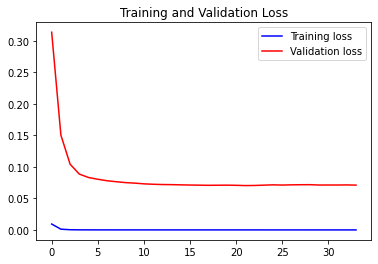

In [167]:

loss = trans_history.history['loss']
val_loss = trans_history.history['val_loss']
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

###Analysing Results

In [168]:
pred_trans = trans_model.predict(X_test)
#predicted_stock_price_multi_head = scaler.inverse_transform(predicted_stock_price_multi_head)


pred_trans.shape

pred_trans = np.vstack((np.full((120,1), np.nan), pred_trans))

In [169]:
rem_pred_trans = pred_trans[120:]
rem_pred_trans.shape

(5705, 1)

In [170]:
convert_trans = scale_close.inverse_transform(rem_pred_trans)

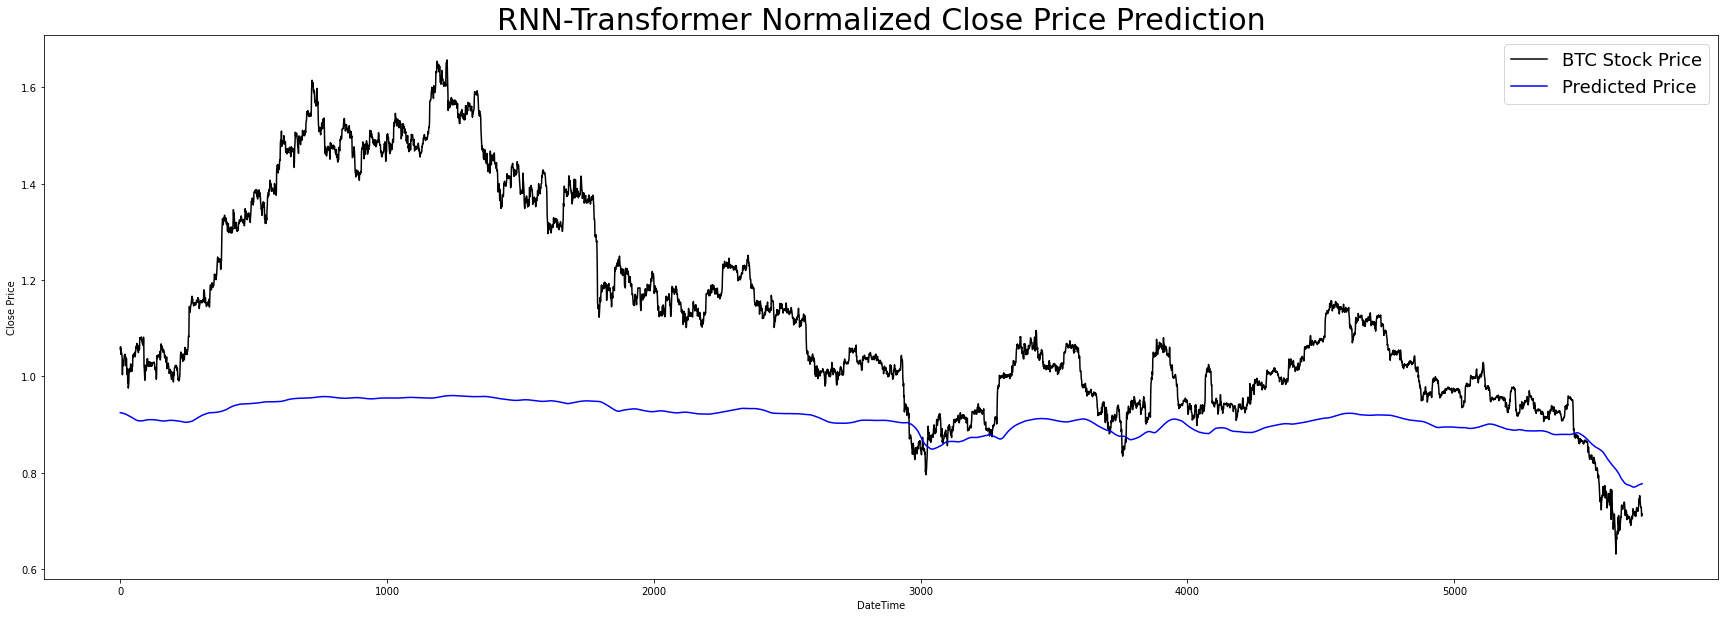

In [176]:
plt.figure(figsize=(30, 10))
plt.plot(y_test, color = 'black', label = 'BTC Stock Price')
plt.plot(rem_pred_trans, color = 'blue', label = 'Predicted Price')
plt.title('RNN-Transformer Normalized Close Price Prediction', fontsize=30)
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('DateTime')
plt.ylabel('Close Price')
plt.legend(fontsize=18)
plt.show()

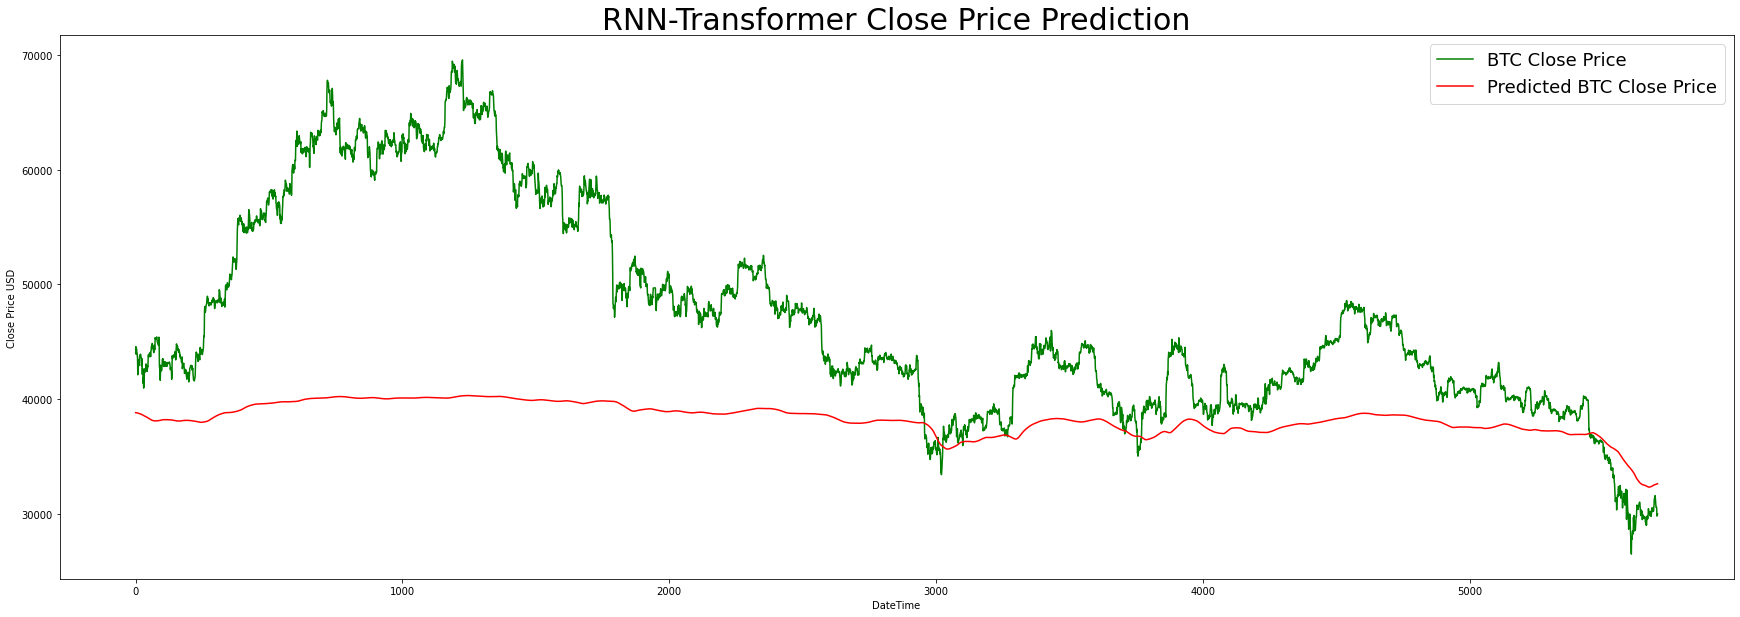

In [174]:
plt.figure(figsize=(30, 10))
plt.plot(original_test, color = 'green', label = 'BTC Close Price')
plt.plot(convert_trans, color = 'red', label = 'Predicted BTC Close Price')
plt.title('RNN-Transformer Close Price Prediction', fontsize=30)
plt.xlabel('DateTime')
plt.ylabel('Close Price USD')
plt.legend(fontsize=18)
plt.show()
plt.close()

In [173]:
from sklearn.metrics import *

expy = explained_variance_score(y_test, rem_pred_trans)
expy_string = 'Explained Variance Score : {}'.format(expy)
print(expy_string)
max_error(y_test, rem_pred_trans)
mean_absolute_error(y_test, rem_pred_trans)
mean_squared_error(y_test, rem_pred_trans)
mean_squared_log_error(y_test, rem_pred_trans)
median_absolute_error(y_test, rem_pred_trans)
mape = mean_absolute_percentage_error(y_test, rem_pred_trans)
mape_string = 'Mean Absolute Percentage Error : {}'.format(mape)
print(mape_string)
r2_score(y_test, rem_pred_trans)
mpd = mean_poisson_deviance(y_test, rem_pred_trans)
mean_gamma_deviance(y_test, rem_pred_trans)
mean_tweedie_deviance(y_test, rem_pred_trans)
d2_tweedie_score(y_test, rem_pred_trans)
mean_pinball_loss(y_test, rem_pred_trans)


r2 =r2_score(y_test, rem_pred_trans)
r2_string = 'R2 Score : {}'.format(r2)
print(r2_string)

Explained Variance Score : 0.25522234640864305
Mean Absolute Percentage Error : 0.17195781254853773
R2 Score : -0.7017785723228909


#Overall Analysis

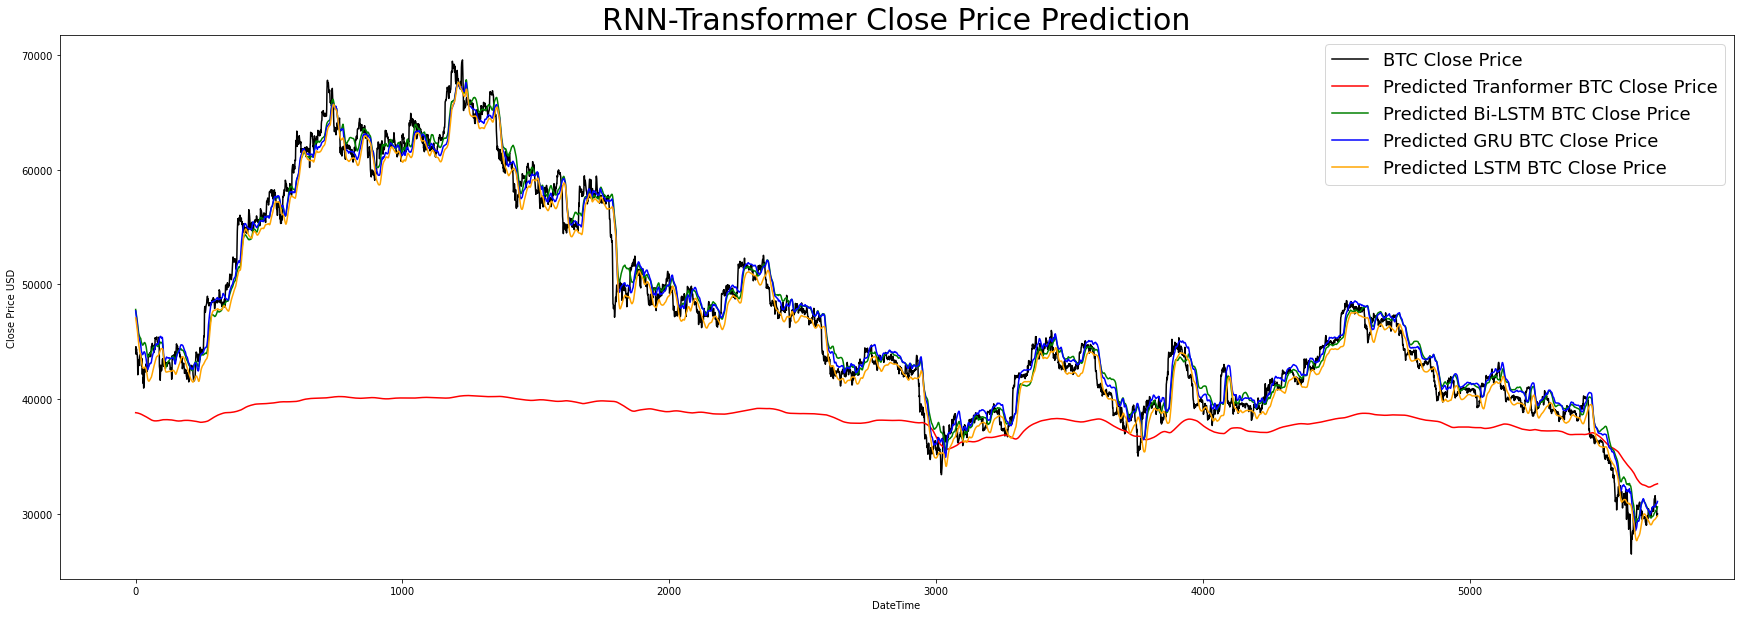

In [183]:
plt.figure(figsize=(30, 10))
plt.plot(original_test, color = 'black', label = 'BTC Close Price')
plt.plot(convert_trans, color = 'red', label = 'Predicted Tranformer BTC Close Price')
plt.plot(convert_bi, color = 'green', label = 'Predicted Bi-LSTM BTC Close Price')
plt.plot(convert_gru, color = 'blue', label = 'Predicted GRU BTC Close Price')
plt.plot(convert_lstm, color = 'orange', label = 'Predicted LSTM BTC Close Price')
plt.title('RNN-Transformer Close Price Prediction', fontsize=30)
plt.xlabel('DateTime')
plt.ylabel('Close Price USD')
plt.legend(fontsize=18)
plt.show()
plt.close()